In [1]:
#!pip install arch

In [ ]:
#!pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [35]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
%cd /content/drive/My Drive/Colab Files/TP 1 - Series de tiempo/
file = 'Series_turismo_interno_&_salario_real.xlsx'

/content/drive/My Drive/Colab Files/TP 1 - Series de tiempo


In [63]:
df_turismo = pd.read_excel(file, sheet_name = 'tur_interno_gau')
df_salario = pd.read_excel(file, sheet_name = 'sal_real_sa')

# **Transformación de los DataFrames**

### Transformación DataFrame "Turismo"


In [38]:
# Vemos el tipo de datos del dataset Turismo
df_turismo.dtypes

trim                 int64
anio                 int64
tur_interno_gau      int64
sal_real_sa        float64
dtype: object

In [39]:
# Verificamos si hay nulos (False = No hay nulos)
print(df_turismo.isnull().values.any())

False


In [40]:
# Transformamos los datos importados
df_turismo = df_turismo.astype({"anio":'int', "trim":'int'}) 
df_turismo['fecha'] = df_turismo['anio'].astype(str) + 'Q' + df_turismo['trim'].astype(str)
df_turismo['fecha'] = pd.to_datetime(df_turismo['fecha'])
df_turismo = df_turismo[['fecha', 'tur_interno_gau']]

In [41]:
# Seteamos como índice la fecha
df_turismo.set_index("fecha", inplace=True)

In [42]:
# Verificamos dataset luego de aplicar transformaciones
df_turismo.head()

,tur_interno_gau
fecha,
2012-01-01,12473866
2012-04-01,5424464
2012-07-01,5484864
2012-10-01,5947386
2013-01-01,11269540


In [43]:
df_turismo.dtypes

tur_interno_gau    int64
dtype: object

### Transformación DataFrame "Salario"

In [64]:
# Vemos el tipo de datos del dataset Salario
df_salario.dtypes

fecha          datetime64[ns]
sal_real_sa           float64
dtype: object

In [65]:
# Verificamos si hay nulos (False = No hay nulos)
print(df_salario.isnull().values.any())

False


In [66]:
# Transformamos los datos importados
df_salario['fecha'] = pd.to_datetime(df_salario['fecha'])
df_salario.set_index("fecha", inplace=True)
#df_salario = df_salario.asfreq('m')

In [67]:
# Verificamos dataset luego de aplicar transformaciones
df_salario.head()

,sal_real_sa
fecha,
1995-01-01,118652.89
1995-02-01,117104.75
1995-03-01,116864.83
1995-04-01,113266.19
1995-05-01,114390.77


In [68]:
df_salario.dtypes

sal_real_sa    float64
dtype: object

# **Análisis Gráfico de las Series de Tiempo**

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as tsa

In [51]:
# Función para graficar juntas las funciones: FAS: autocovarianzas; FAC y FACP: autocorrelación y autocorrelación parcial
def autocov_autocorr(serie, nrol= 40 ):
  p1, axes=plt.subplots(3,1,figsize=(18,10),sharex=True, sharey=False )
  axes[0].set_xlabel('lag')
  axes[1].set_xlabel('lag')
  axes[1].set_xlabel('lag')
  axes[0].set_ylabel('FAC')
  axes[1].set_ylabel('FACP')
  axes[2].set_ylabel('FAS')

  plot_acf(serie, lags=nrol, ax= axes[0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'},title='')
  plot_pacf(serie, lags=nrol, ax= axes[1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2].plot(tsa.acovf(serie,fft=False, nlag=nrol), color='r', label='FAS')
  
  p1.legend()
  plt.show()

# Función para graficar la descomposición de la serie en componentes para ver estacionalidad, tendencia, residuos 
def componentes(timeserie):
  decomposition = seasonal_decompose(timeserie, model = "adittive")
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(18, 8)

### Análisis de la serie de tiempo de TURISMO INTERNO

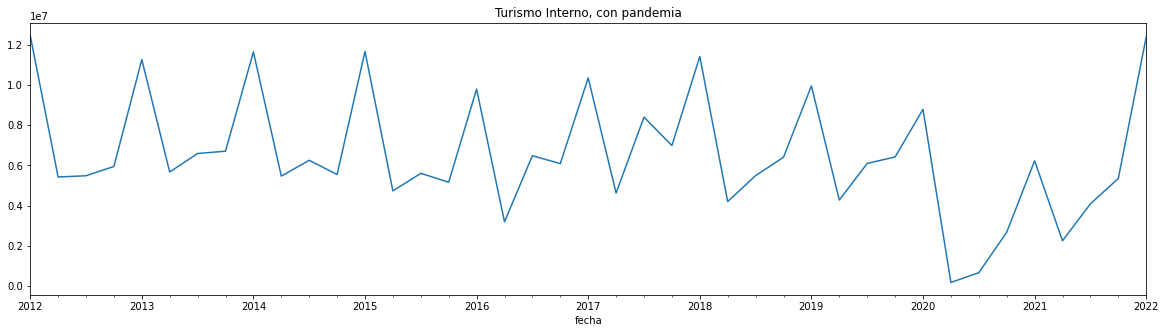

In [52]:
# Graficamos la serie de Turismo Interno
df_turismo.tur_interno_gau.plot(figsize=(20,5), title = 'Turismo Interno, con pandemia')
plt.show()

En el gráfico se observa que la pandemia generó un comportamiento muy diferente al que exhibe la serie en períodos pasados. Por esta razón se decide eliminar de la serie los períodos afectados por la pandemia. 

In [53]:
#SIN PANDEMIA. Tomamos hasta el último cuatrimestre de 2019.
df_turismo_cut = df_turismo[df_turismo.index <= '2019-10-01']

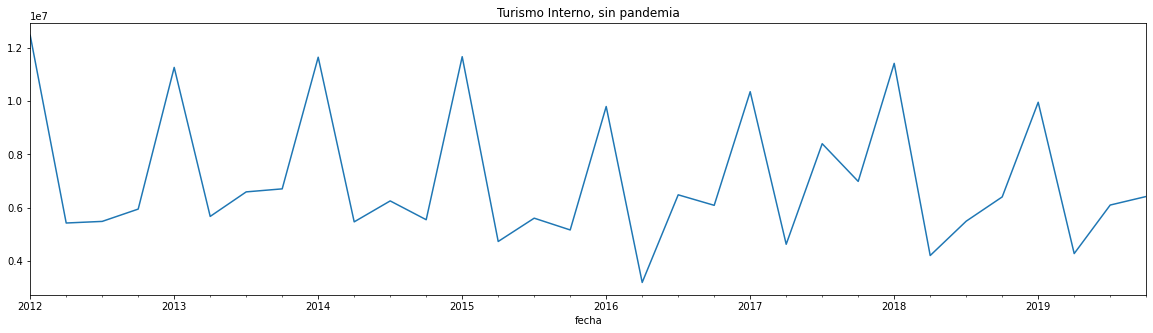

In [54]:
df_turismo_cut.tur_interno_gau.plot(figsize=(20,5), title = 'Turismo Interno, sin pandemia')
plt.show()

<Figure size 432x288 with 0 Axes>

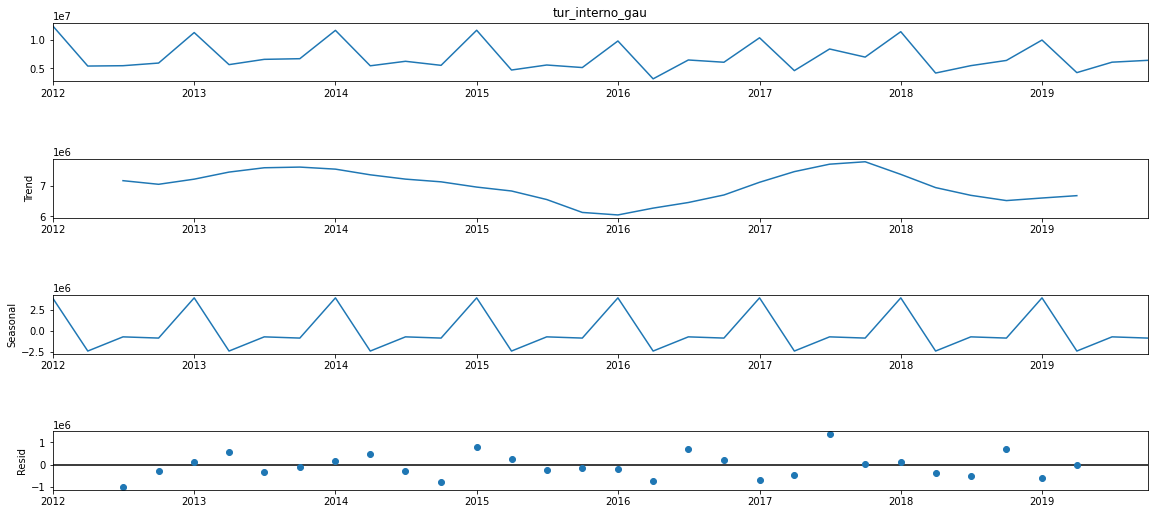

In [55]:
componentes (df_turismo_cut.tur_interno_gau)

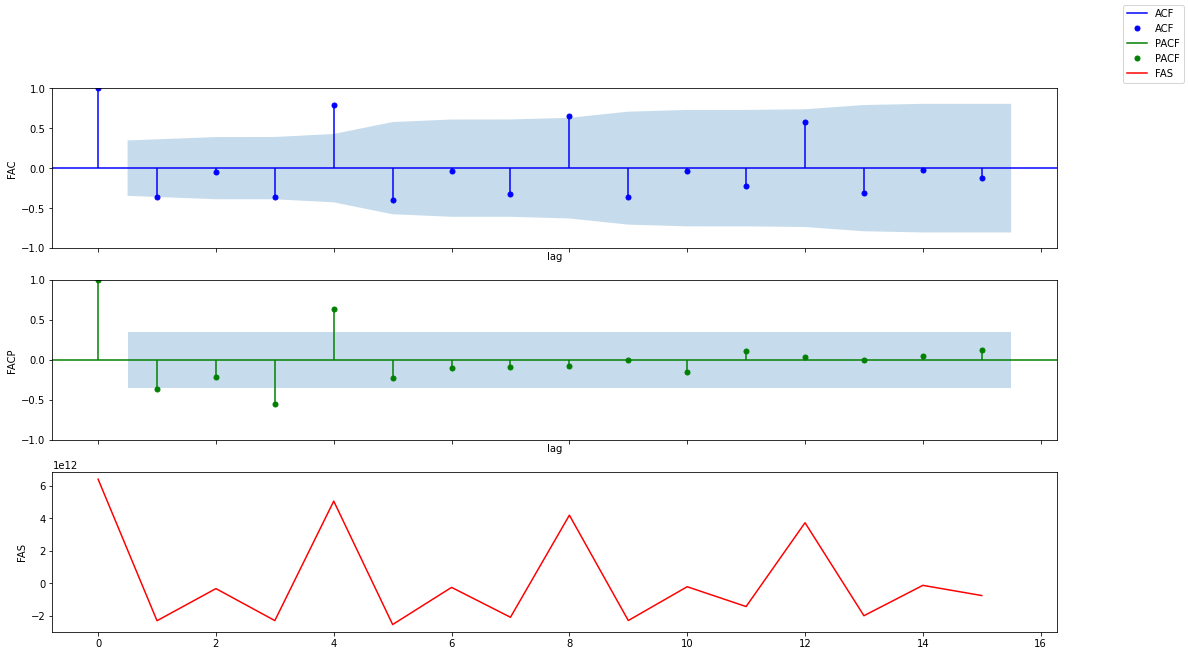

In [56]:
# Gráfico FAC, FACP, FAS para la serie de Turismo (sin pandemia)
autocov_autocorr(df_turismo_cut, 15)

Observando el gráfico, la serie aparenta ser estacionaria (algo que se revisará luego con tests específicos para el caso) por ende, no sería necesario diferenciarla. Por otro lado, los picos de la FAC denotan estacionalidad, algo a considerar en el modelo, lo que nos indica utilizar un SARIMA. La disminución gradual de la FAC denota un proceso AR. Mirando la FACP, se ve que el lag relevante es el 4, es decir un año atrás, y quizás el lag 5. Como es una serie estacional, y vamos a usar un SARIMA, no podemos considerar un lag igual o mayor a la frecuencia de la serie, ya que estaríamos duplicando los lags a incorporar en el modelo. Por lo tanto, podemos probar con un AR(3) o un AR(0). Un AR(3) debido a que así tomaríamos los lags 1, 2 y 3 y luego en la parte estacional, incluiríamos el lag 4. Para un AR(0) los tres primeros lags no son significativos según la FACP. Por su lado, no encontramos evidencias que indiquen el orden de un proceso MA, por lo que se podrían probar diferentes alternativas para un MA. En princpio podemos probar un MA(1). En conclusión se podrían probar dos alternativas para la parte no estacional del modelo: ARIMA(3,0,1) y ARIMA(0,0,1).

#### **Diferencia estacional**

Para remover la estacionalidad anual, probamos una diferenciación estacional, con respecto a t-4, es decir un año atrás.

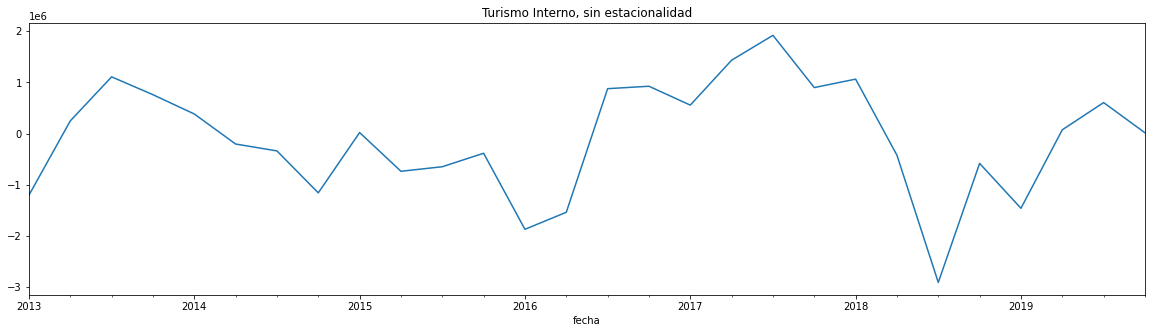

In [57]:
df_turismo_cut_diff_4 = df_turismo_cut - df_turismo_cut.shift(4)
df_turismo_cut_diff_4 = df_turismo_cut_diff_4.dropna()
df_turismo_cut_diff_4.tur_interno_gau.plot(figsize=(20,5), title = 'Turismo Interno, sin estacionalidad')
plt.show()

<Figure size 432x288 with 0 Axes>

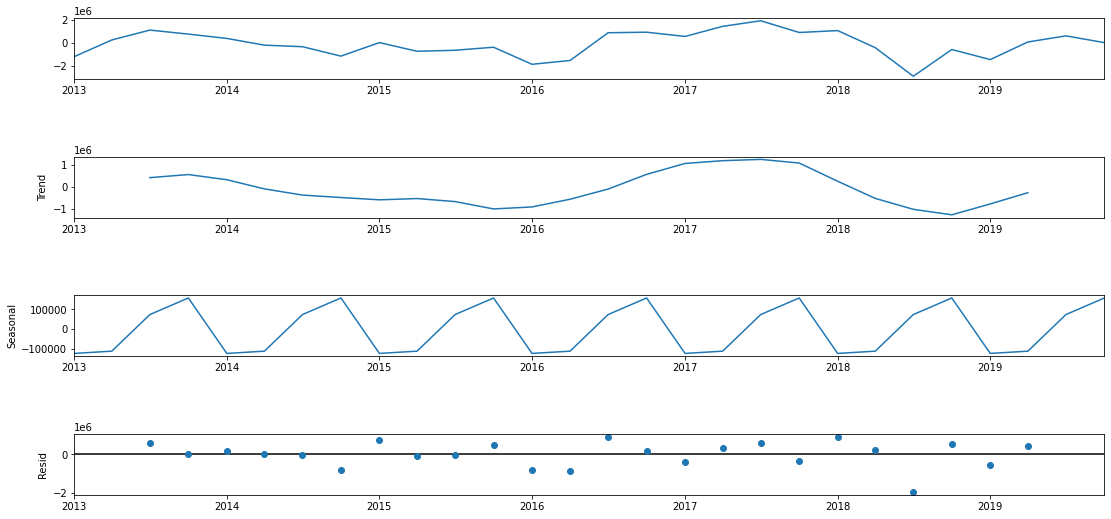

In [58]:
componentes (df_turismo_cut_diff_4)

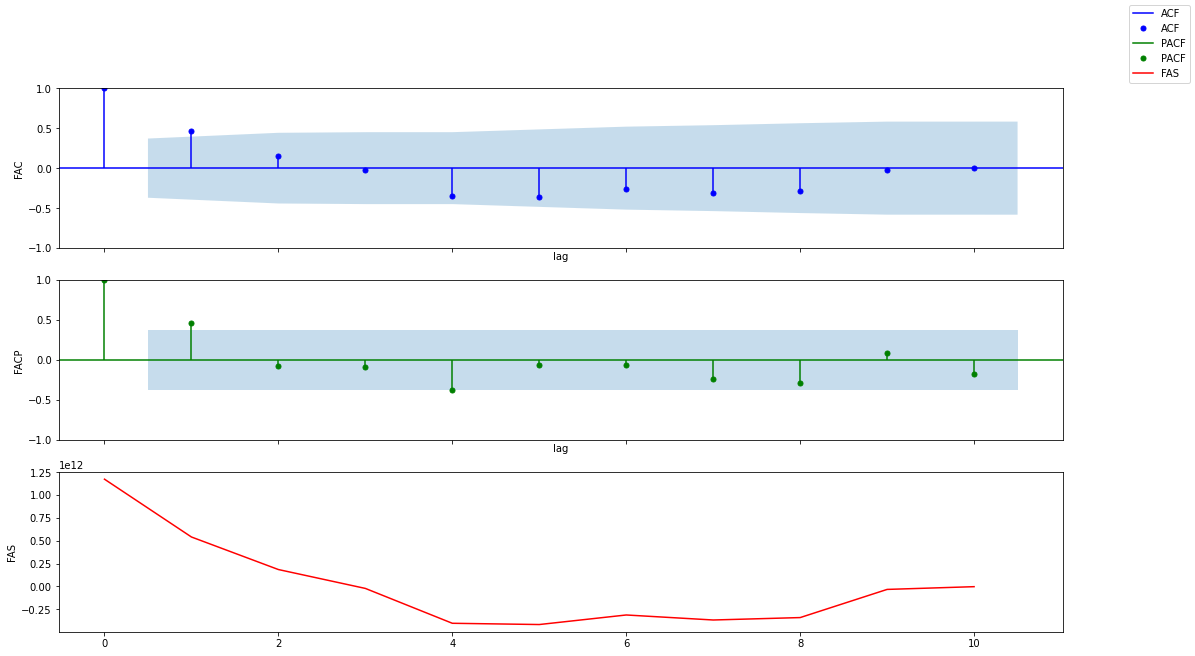

In [59]:
autocov_autocorr(df_turismo_cut_diff_4, 10)

En el gráfico de la serie ya no observamos un patrón repetitivo, por lo que se elimina la estacionalidad con una primera diferencia estacional. A su vez, en el gráfico de la FAC se ve que se reduce gradualmente, indicando un proceso AR, y en el gráfico de la FACP se ve que el único lag relevante es el 1. Por lo tanto, los parámetros a probar, del componente estacional de esta serie, serían (1,1,0,4).

### Análisis de la serie de tiempo de SALARIO REAL EN PESOS DESESTACIONALIZADO

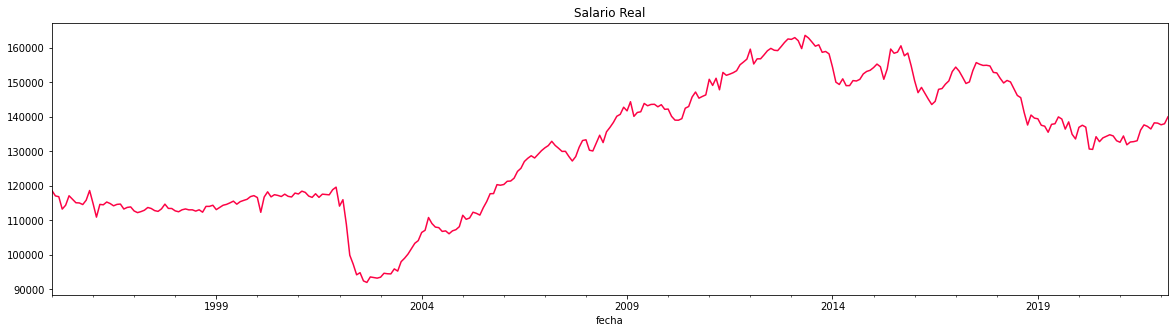

In [69]:
df_salario.sal_real_sa.plot(figsize=(20,5), color='#fc0345', title = 'Salario Real')
plt.show()

A partir del gráfico se observa un comportamiento muy disímil en la década de los 90 que puede afectar la estimación de los parámetros del modelo. Por esta razón decidimos quedarnos solo con el período desde el año 2003.

In [70]:
df_salario_cut = df_salario[df_salario.index >= '2003-01-01']

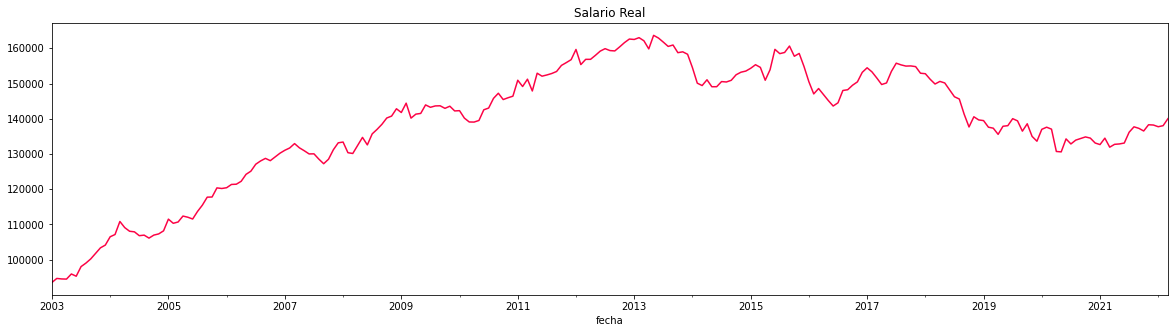

In [71]:
df_salario_cut.sal_real_sa.plot(figsize=(20,5), color='#fc0345', title = 'Salario Real')
plt.show()

<Figure size 432x288 with 0 Axes>

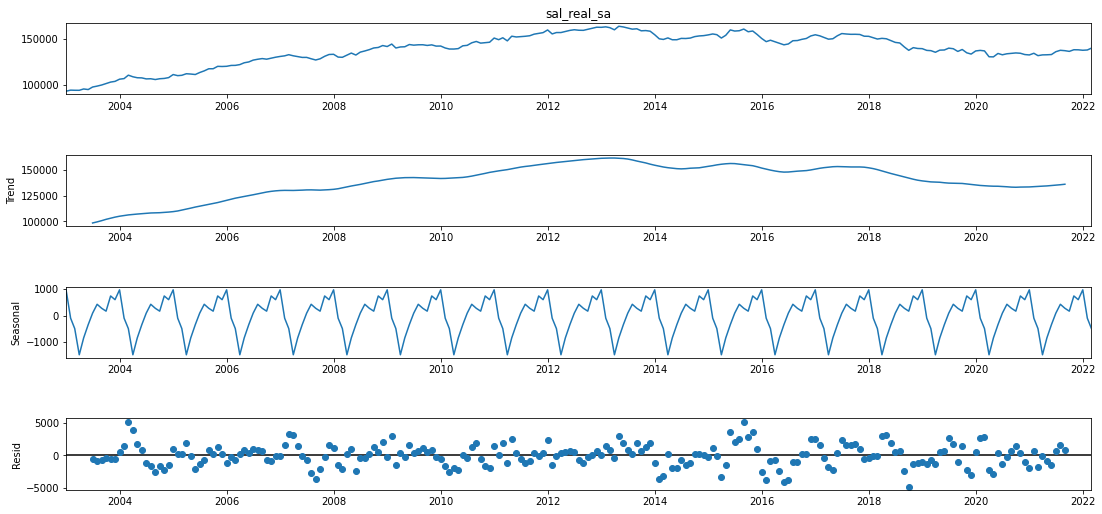

In [72]:
componentes (df_salario_cut.sal_real_sa)

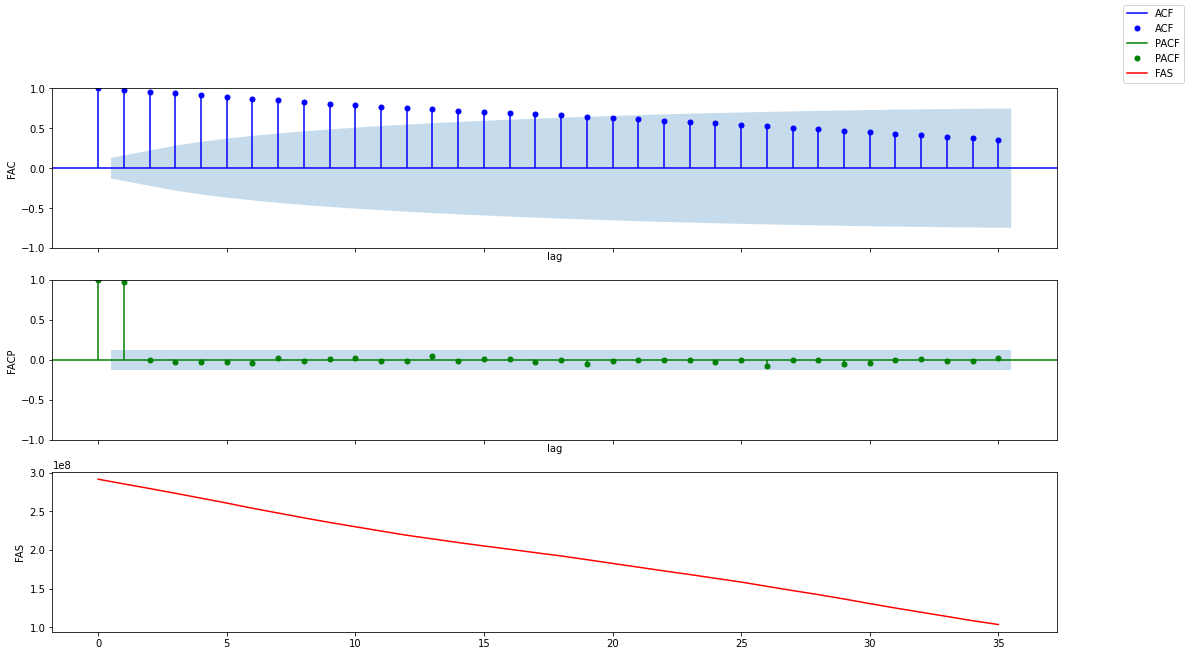

In [73]:
autocov_autocorr(df_salario_cut, 35)

La disminución lineal de la FAC denota NO estacionariedad y probablemente un proceso AR. En principio habría que diferenciar la serie para lograr estacionariedad. El gráfico de la FACP decae abruptamente luego del lag 1, por ende, una primera aproximación a un modelo para esta serie podría ser un ARIMA(1,1,0)

#### **Primera Diferencia**

Probamos una primera diferencia de la serie para ver si logramos estacionariedad

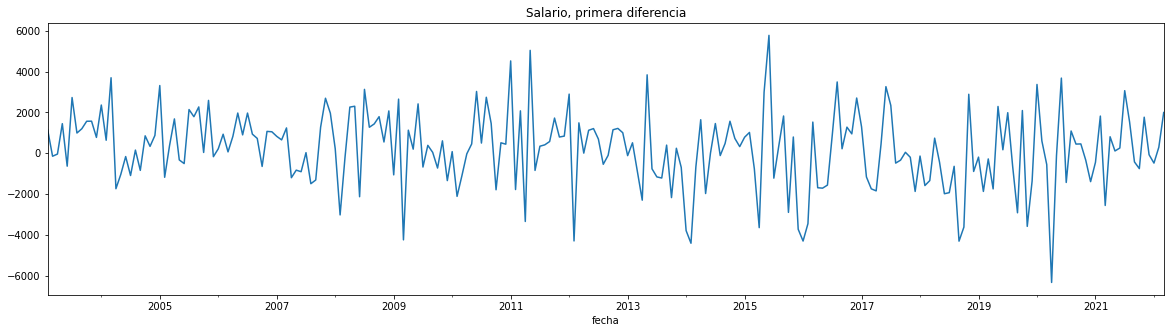

In [74]:
df_salario_cut_diff_1 = df_salario_cut - df_salario_cut.shift(1)
df_salario_cut_diff_1 = df_salario_cut_diff_1.dropna()
df_salario_cut_diff_1.sal_real_sa.plot(figsize=(20,5), title = 'Salario, primera diferencia')
plt.show()

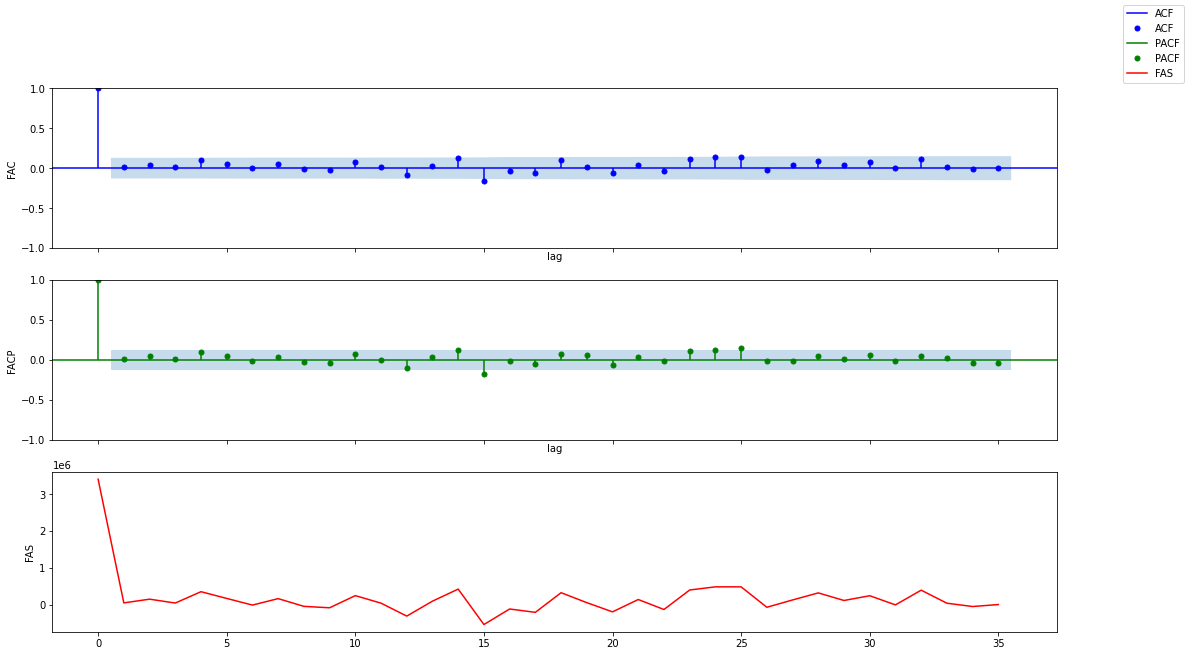

In [75]:
autocov_autocorr(df_salario_cut_diff_1, 35)

El gráfico de la FAC decae abruptamente, lo que sugiere un proceso MA (aunque el gráfico de la FACP no decae gradualmente que sería lo esperable para un proceso MA). Podemos probar entonces un modelo ARIMA(0,1,1).

# **Análisis de Estacionariedad: Tests de Raíces Unitarias**

Analizaremos mediente distintas pruebas la estacionaridad de la serie. Se realizan tres test de raíz unitaria: Augmented Dickey Fuller (La H0 es que la serie es NO ESTACIONARIA), KPSS (La H0 es que la serie es ESTACIONARIA) y Phillips-Perron (La H0 es que la serie es NO ESTACIONARIA). 

In [76]:
from statsmodels.tsa.stattools import adfuller, kpss

In [77]:
# Función para realizar test Dickey Fuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Results of Dickey-Fuller Test for column: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Reject the null hypothesis")
    print("Data is stationary")
  else:
    print("Conclusion:====>")
    print("Fail to reject the null hypothesis")
    print("Data is non-stationary")

In [78]:
# Función para realizar test KPPS
def kpss_test(timeseries, regression):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression)#, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    if kpsstest[1] <= 0.05:
      print("Conclusion:====>")
      print("Reject the null hypothesis")
      print("Data is non-stationary")
    else:
      print("Conclusion:====>")
      print("Fail to reject the null hypothesis")
      print("Data is stationary")

In [79]:
import arch.unitroot as at
from pmdarima import arima

In [80]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = arima.ndiffs(y, test='adf')  # -> 0
  
  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = arima.ndiffs(y, test='kpss')  # -> 0
  
  # PP test: Phillips-Perron
  n_pp = arima.ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)
  
  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)
  
  print('Estimado de número de diferencias con PP test')
  print(n_pp)
  
  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = arima.ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

### Tests de raíz unitaria para la serie TURISMO INTERNO

In [81]:
Augmented_Dickey_Fuller_Test_func(df_turismo_cut["tur_interno_gau"], "tur_interno_gau")

Results of Dickey-Fuller Test for column: tur_interno_gau
Test Statistic                 -2.371693
p-value                         0.149886
No Lags Used                    4.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [82]:
kpss_test(df_turismo_cut["tur_interno_gau"],"c") # incorporamos solo una constante como compontente determinístico del modelo para el test, porque en los gráficos no se observa una time trend

Results of KPSS Test:
Test Statistic            0.414758
p-value                   0.070794
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is stationary


In [83]:
at.PhillipsPerron(df_turismo_cut["tur_interno_gau"], trend = "c", test_type = "tau")

Test Statistic,-13.130
P-value,0.000
Lags,10


CONCLUSIÓN: según el test de Dickey-Fuller Aumentado, la serie de turismo interno es no estacionaria, pero para las pruebas de KPSS y Phillips-Perron es estacionaria. A continuación se ve que solo el test ADF sugiere diferenciar la serie.

In [84]:
estacionario(df_turismo_cut["tur_interno_gau"])

Estimado de número de diferencias con ADF test
2
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.8096689975384076, True)


A continuación vemos la cantidad sugerida de veces que hay que diferenciar la serie de manera estacional es 1, tal como lo habíamos comprobado en el apartado de análisis gráfico de la serie temporal:

In [85]:
arima.nsdiffs(df_turismo_cut, m=4) 

1

### Tests de raíz unitaria para la serie SALARIOS

In [86]:
Augmented_Dickey_Fuller_Test_func(df_salario['sal_real_sa'], 'sal_real_sa')

Results of Dickey-Fuller Test for column: sal_real_sa
Test Statistic                  -0.956044
p-value                          0.768957
No Lags Used                     0.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [87]:
kpss_test(df_salario['sal_real_sa'], "ct") # incorporamos tanto constante como time trend porque porque en los gráficos se observa dependencia en función del tiempo. 

Results of KPSS Test:
Test Statistic            0.328471
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is non-stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [88]:
at.PhillipsPerron(df_salario['sal_real_sa'], trend = "ct", test_type = "tau")

Test Statistic,-1.605
P-value,0.790
Lags,17


CONCLUSIÓN: La serie de salarios es no estacionaria según las tres pruebas realizadas.

A continuacion, analizamos el orden de diferenciacion requerido para que la serie de salarios pueda llegar a ser estacionaria, según las diferentes pruebas de hipótesis de raíz unitaria.

In [89]:
estacionario(df_salario['sal_real_sa'])

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.7020319304114836, True)


En conclusión se debería diferenciar solo la serie de salarios 1 vez, tal como se había concluido en la sección de análisis gráfico de la serie temporal.

# **Modelos**


In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

### Modelos para la serie de TURISMO INTERNO

Según la información de la exploración anterior, deberíamos tener un modelo SARIMA para la serie de turismo. Se probarán dos sets de parámetros SARIMA:

>  a) SARIMA(1,0,1)(1,1,0,4)

>  b) SARIMA(0,0,1)(1,1,0,4)

En primer lugar, separamos un conjunto de training y otro de testing. Debido a que es una serie con muy pocos datos históricos, tomamos como testing solo 1 año:

In [91]:
train_turismo = df_turismo_cut[df_turismo_cut.index <= "2018-10-01"]
test_turismo = df_turismo_cut[df_turismo_cut.index > "2018-10-01"]

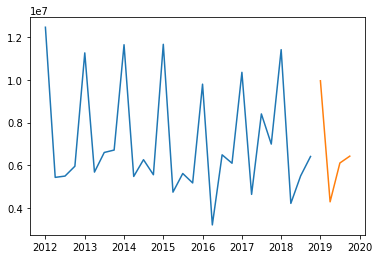

In [92]:
plt.plot(train_turismo)
plt.plot(test_turismo)

In [93]:
# Modelo A: SARIMA(1,0,1)(1,1,0,4) 
modelo_turismo_a = SARIMAX(train_turismo, order=(1,0,1), seasonal_order=(1,1,0,4))
modelo_turismo_a_fit = modelo_turismo_a.fit()
print(modelo_turismo_a_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    tur_interno_gau   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 4)   Log Likelihood                -364.201
Date:                            Tue, 09 Aug 2022   AIC                            736.401
Time:                                    16:51:18   BIC                            741.114
Sample:                                01-01-2012   HQIC                           737.651
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3319      0.222     -1.497      0.135      -0.767       0.103
ma.L1          0.9243      0.136   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


En este modelo A se observa que solo el parámetro ma.L1 es significativo.

In [94]:
# Modelo b: SARIMA(0,0,1)(1,1,0,4) 
modelo_turismo_b = SARIMAX(train_turismo, order=(0,0,1), seasonal_order=(1,1,0,4))
modelo_turismo_b_fit = modelo_turismo_b.fit()
print(modelo_turismo_b_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    tur_interno_gau   No. Observations:                   28
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 4)   Log Likelihood                -365.916
Date:                            Tue, 09 Aug 2022   AIC                            737.832
Time:                                    16:51:18   BIC                            741.366
Sample:                                01-01-2012   HQIC                           738.769
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7833      0.146      5.374      0.000       0.498       1.069
ar.S.L4       -0.2142      0.106   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


En este modelo B se observa que todos los parámetros son significativos, aunque los 3 criterios de información del Modelo A son mejores.


Finalmente, hacemos una prueba con un auto-arima para ver los parámetros sugeridos por el modelo automático:

In [95]:
# Auto-ARIMA
stepwise_model1 = auto_arima(train_turismo,start_p=1, start_q=1,
max_p=7, max_q=7, seasonal=True, start_P=1, start_Q=1, m=4,
d=None, trace=True,error_action='ignore',suppress_warnings=True,
stepwise=True)
stepwise_model1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[4] intercept   : AIC=740.195, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=740.947, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=741.378, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=739.346, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=739.355, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=741.331, Time=0.08 sec
 ARIMA(0,0,1)(0,1,2)[4] intercept   : AIC=741.315, Time=0.07 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=739.927, Time=0.06 sec
 ARIMA(0,0,1)(1,1,2)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=742.722, Time=0.04 sec
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=738.350, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=737.034, Time=0.07 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=738.420, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=743.226, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 4)   Log Likelihood                -364.552
Date:                            Tue, 09 Aug 2022   AIC                            735.103
Time:                                    16:51:21   BIC                            738.638
Sample:                                         0   HQIC                           736.041
                                             - 28                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3825      0.198     -1.932      0.053      -0.770       0.005
ma.L1          0.9473      0.127      7.439      0.000       0.698       1.197
sigma2      9.817e+11   1.17e-14   8.38e+25      0.000    9.82e+11    9.82e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.42   Prob(JB):                         0.60
Heteroskedasticity (H):               2.48   Skew:                            -0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.85e+41. Standard errors may be unstable.
"""

Se observa que el mejor modelo es un SARIMA(1,0,1)(0,1,0,4). De hecho, los 3 criterios de información reportados son mejores para este modelo que para los modelos A y B propuestos por nosotros. 

In [96]:
# Modelo best: SARIMA(1,0,1)(0,1,0,4) 
modelo_turismo_best = SARIMAX(train_turismo, order=(1,0,1), seasonal_order=(0,1,0,4))
modelo_turismo_best_fit = modelo_turismo_best.fit()
print(modelo_turismo_best_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    tur_interno_gau   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 4)   Log Likelihood                -364.552
Date:                            Tue, 09 Aug 2022   AIC                            735.103
Time:                                    16:51:21   BIC                            738.638
Sample:                                01-01-2012   HQIC                           736.041
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3825      0.198     -1.932      0.053      -0.770       0.005
ma.L1          0.9473      0.127   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


### Modelos para la serie de SALARIOS

Según la información de la exploración anterior se probarán los siguientes sets de parámetros ARIMA para la serie de salarios:

>  a) ARIMA(1,1,0) (surge del análisis de la serie sin diferenciar)

>  b) ARIMA(0,1,1) (surge del análisis de la serie en primera diferencia)

> c) ARIMA(1,1,1) (combinación de las alternativas anteriores)

En primer lugar, separamos un conjunto de training y otro de testing. Tomamos como testing 2 años de información:

In [97]:
train_salario = df_salario_cut[:-24]
test_salario = df_salario_cut[-24:] #24 meses de testing

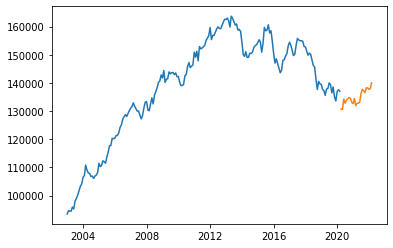

In [98]:
plt.plot(train_salario)
plt.plot(test_salario)

In [99]:
# Modelo a: ARIMA(1,1,0)
modelo_salario_a = SARIMAX(train_salario, order=(1,1,0))
modelo_salario_a_fit = modelo_salario_a.fit()
print(modelo_salario_a_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            sal_real_sa   No. Observations:                  207
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1841.338
Date:                Tue, 09 Aug 2022   AIC                           3686.676
Time:                        16:51:22   BIC                           3693.331
Sample:                    01-01-2003   HQIC                          3689.367
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0181      0.058      0.311      0.756      -0.096       0.132
sigma2      3.415e+06    3.2e+05     10.674      0.000    2.79e+06    4.04e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Se observa que el parámetro del primer lag (ar.L1) no es significativo, por lo que este no es un buen modelo. 

In [100]:
# Modelo b: ARIMA(0,1,1)
modelo_salario_b = SARIMAX(train_salario, order=(0,1,1))
modelo_salario_b_fit = modelo_salario_b.fit()
print(modelo_salario_b_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            sal_real_sa   No. Observations:                  207
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1841.357
Date:                Tue, 09 Aug 2022   AIC                           3686.713
Time:                        16:51:22   BIC                           3693.369
Sample:                    01-01-2003   HQIC                          3689.405
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0177      0.059      0.299      0.765      -0.098       0.134
sigma2      3.457e+06   3.28e+05     10.547      0.000    2.81e+06     4.1e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Se observa que el parámetro del primer lag del componente MA (ma.L1) no es significativo, por lo que este tampoco es un buen modelo. 

In [101]:
# Modelo c: ARIMA(1,1,1)
modelo_salario_c = SARIMAX(train_salario, order=(1,1,1))
modelo_salario_c_fit = modelo_salario_c.fit()
print(modelo_salario_c_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            sal_real_sa   No. Observations:                  207
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1837.115
Date:                Tue, 09 Aug 2022   AIC                           3680.231
Time:                        16:51:22   BIC                           3690.214
Sample:                    01-01-2003   HQIC                          3684.268
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9845      0.014     71.909      0.000       0.958       1.011
ma.L1         -0.9745      0.019    -50.795      0.000      -1.012      -0.937
sigma2      3.264e+06   1.28e-10   2.54e+16      0.0

Este tercer modelo es mejor que los dos anteriores porque los parámetros estimados son relevantes y los 3 criterios de información son menores.

Finalmente, hacemos una prueba con un auto-arima para ver los parámetros sugeridos por el modelo automático:

In [102]:
# Auto-ARIMA
stepwise_model2 = auto_arima(train_salario,start_p=1, start_q=1,
max_p=7, max_q=7, seasonal=False,
d=None, trace=True,error_action='ignore',suppress_warnings=True,
stepwise=True)
stepwise_model2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3804.826, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3797.513, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3795.505, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3802.838, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=3787.110, Time=0.30 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=3790.923, Time=0.27 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=3789.978, Time=0.57 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3785.471, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3793.592, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3775.706, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3790.531, Time=0.49 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=3794.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -1883.853
Date:                Tue, 09 Aug 2022   AIC                           3775.706
Time:                        16:51:27   BIC                           3788.998
Sample:                             0   HQIC                          3781.082
                                - 207                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3082      0.031     -9.828      0.000      -0.370      -0.247
ma.L2         -0.2184      0.023     -9.624      0.000      -0.263      -0.174
ma.L3         -0.1256      0.015     -8.495      0.000      -0.155      -0.097
sigma2      5.571e+06   2.13e-10   2.61e+16      0.000    5.57e+06    5.57e+06
===================================================================================
Ljung-Box (L1) (Q):                  20.76   Jarque-Bera (JB):                 4.88
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               1.15   Skew:                            -0.18
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.66e+32. Standard errors may be unstable.
"""

El mejor modelo según el auto arima es un ARIMA(0,2,3). Todos los parámetros estimados son relevantes. Sin embargo los 3 criterios de información son mayores que el modelo ARIMA (1,1,1) estimado anteriormente, por lo que aquel sería un mejor modelo que este.

## Métricas de performance



In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [104]:
def metricas(y_true, y_pred):
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  print('Evaluation metric results:-')
  print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
  print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
  print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n')

In [105]:
# Funcion para graficar las predicciones.

def graficar_pred(serie_test, serie_pred, conf_int,
                  titulo="Valores Originales vs Predicciones", xlabel="Fecha", ylabel="Valor"):
  
    fig_x = plt.figure(figsize=(7,4), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    
    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones", linestyle='--')
    
    # Graficamos área de intervalos de confianza
    axes_x.fill_between(conf_int.index,
                        conf_int.iloc[:, 0],
                        conf_int.iloc[:, 1], color='k', alpha=.1)

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend()
    axes_x.grid(True, color='k', alpha=.3, dashes=(5,2))


### Métricas Serie TURISMO



In [106]:
# Convierto el dataframe de test de Turismo en una serie
test_turismo_serie = test_turismo.iloc[:,0]

Modelo (a): SARIMA(1,0,1)(1,1,0,4)


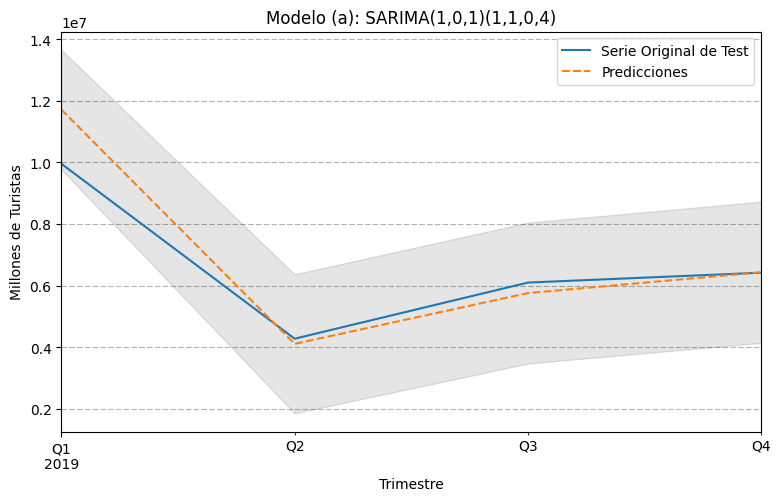

In [107]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (a)
predicciones_modelo_turismo_a = modelo_turismo_a_fit.get_forecast(len(test_turismo_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_turismo_serie, predicciones_modelo_turismo_a.predicted_mean, predicciones_modelo_turismo_a.conf_int(),"Modelo (a): SARIMA(1,0,1)(1,1,0,4)", "Trimestre", "Millones de Turistas")

In [108]:
# Métricas para el Modelo (a): SARIMA (1,0,1)(1,1,0,4)
metricas(test_turismo_serie, predicciones_modelo_turismo_a.predicted_mean)

Evaluation metric results:-
MSE is : 809286066425.4562
MAE is : 570457.0237457997
RMSE is : 899603.282800511
MAPE is : 6.846901884326345
R2 is : 0.8089642233186937



Modelo (b) SARIMA(0,0,1)(1,1,0,4)

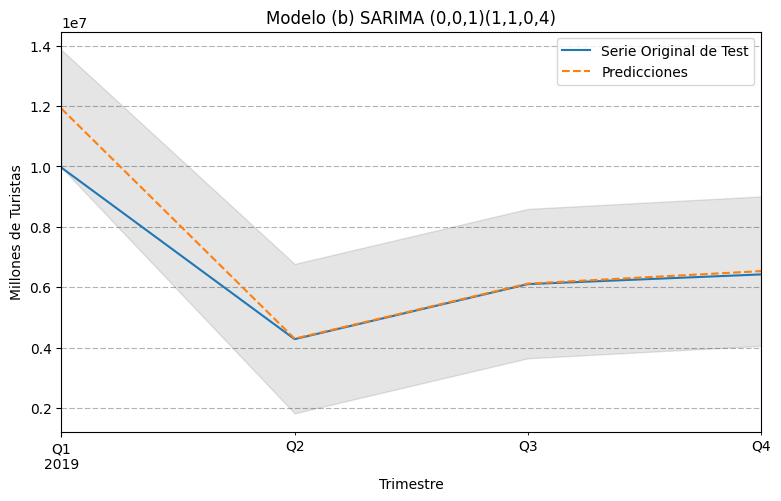

In [109]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (b)
predicciones_modelo_turismo_b = modelo_turismo_b_fit.get_forecast(len(test_turismo_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_turismo_serie, predicciones_modelo_turismo_b.predicted_mean, predicciones_modelo_turismo_b.conf_int(),"Modelo (b) SARIMA (0,0,1)(1,1,0,4)", "Trimestre", "Millones de Turistas")

In [110]:
# Métricas para el Modelo (b) SARIMA (1,0,1)(1,1,0,4)
metricas(test_turismo_serie, predicciones_modelo_turismo_b.predicted_mean)

Evaluation metric results:-
MSE is : 957218082922.8557
MAE is : 524374.1599571537
RMSE is : 978375.2260369514
MAPE is : 5.50102239131876
R2 is : 0.7740441760819536



Modelo (best_fit) SARIMA (1,0,1)(0,1,0,4)

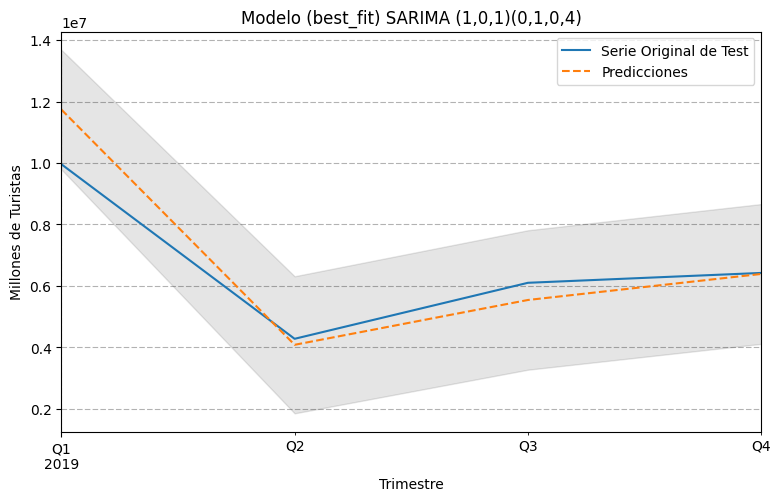

In [111]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (best_fit)
predicciones_modelo_turismo_best_fit = modelo_turismo_best_fit.get_forecast(len(test_turismo_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_turismo_serie, predicciones_modelo_turismo_best_fit.predicted_mean, predicciones_modelo_turismo_best_fit.conf_int(),"Modelo (best_fit) SARIMA (1,0,1)(0,1,0,4)", "Trimestre", "Millones de Turistas")

In [112]:
# Métricas para el Modelo (best_fit) SARIMA (1,0,1)(0,1,0,4)
metricas(test_turismo_serie, predicciones_modelo_turismo_best_fit.predicted_mean)

Evaluation metric results:-
MSE is : 879582365683.3586
MAE is : 641858.5651025756
RMSE is : 937860.525709105
MAPE is : 8.030406429773866
R2 is : 0.7923704517418888



### Métricas Serie SALARIO

In [113]:
# Convierto el dataframe de test de Turismo en una serie
test_salario_serie = test_salario.iloc[:,0]

Modelo (a) ARIMA (1,1,0)

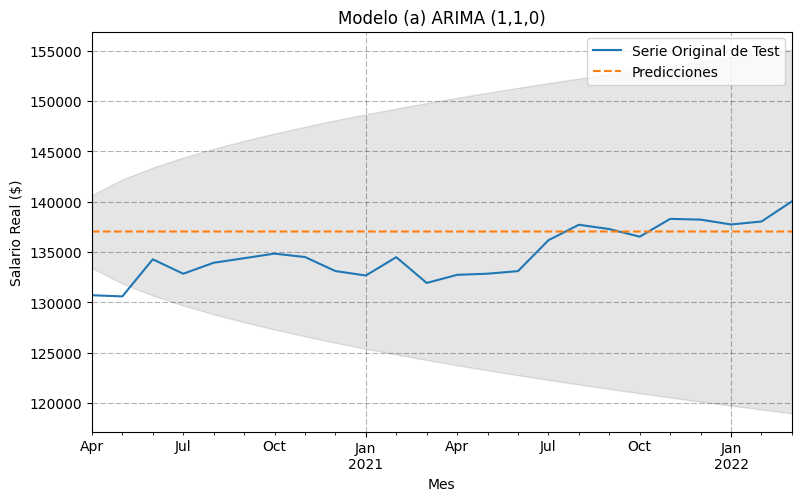

In [114]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (a) ARIMA (1,1,0)
predicciones_modelo_salario_a = modelo_salario_a_fit.get_forecast(len(test_salario_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_salario_serie, predicciones_modelo_salario_a.predicted_mean, predicciones_modelo_salario_a.conf_int(),"Modelo (a) ARIMA (1,1,0)", "Mes", "Salario Real ($)")

In [115]:
# Métricas para el Modelo (a) ARIMA (1,1,0)
metricas(test_salario_serie, predicciones_modelo_salario_a.predicted_mean)

Evaluation metric results:-
MSE is : 11173459.867405983
MAE is : 2833.062714572811
RMSE is : 3342.672563594284
MAPE is : 2.1228696803131717
R2 is : -0.7205164873381977



Modelo (b) ARIMA (0,1,1)

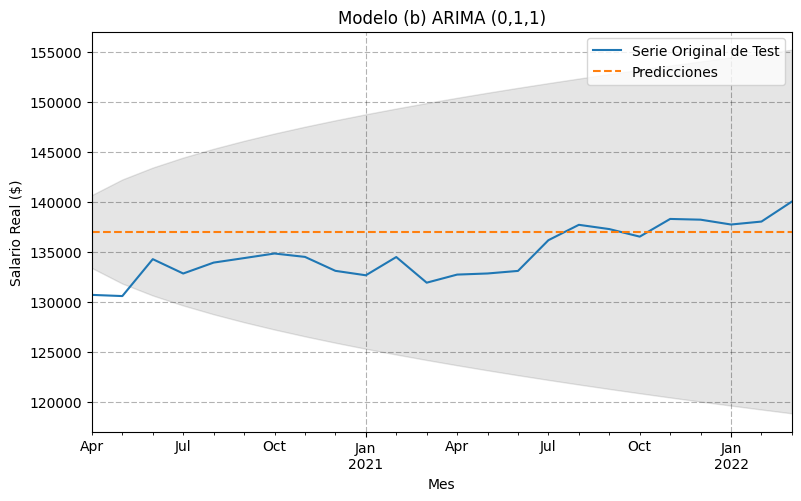

In [116]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (b) ARIMA (0,1,1)
predicciones_modelo_salario_b = modelo_salario_b_fit.get_forecast(len(test_salario_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_salario_serie, predicciones_modelo_salario_b.predicted_mean, predicciones_modelo_salario_b.conf_int(),"Modelo (b) ARIMA (0,1,1)", "Mes", "Salario Real ($)")

In [117]:
# Métricas para el Modelo (b) ARIMA (0,1,1)
metricas(test_salario_serie, predicciones_modelo_salario_b.predicted_mean)

Evaluation metric results:-
MSE is : 11174384.568177849
MAE is : 2833.1534856372014
RMSE is : 3342.8108783145135
MAPE is : 2.122939311399461
R2 is : -0.720658875008868



Modelo (c) ARIMA (1,1,1)

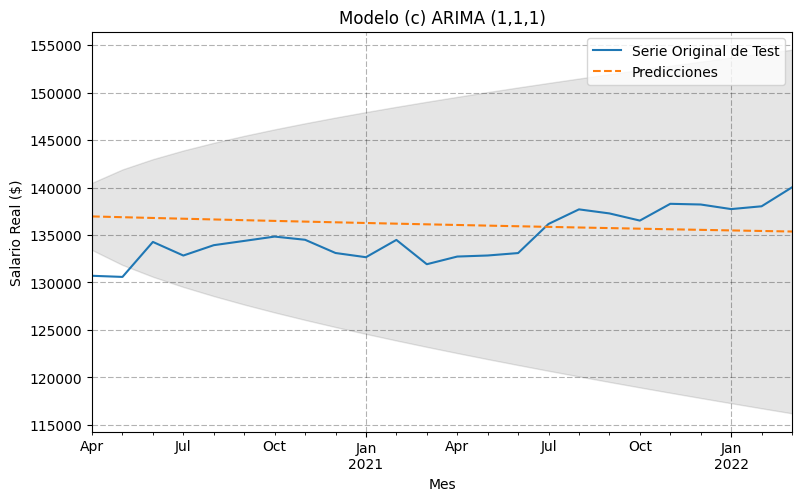

In [118]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test con el modelo (c) ARIMA (1,1,1)
predicciones_modelo_salario_c = modelo_salario_c_fit.get_forecast(len(test_salario_serie))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test_salario_serie, predicciones_modelo_salario_c.predicted_mean, predicciones_modelo_salario_c.conf_int(),"Modelo (c) ARIMA (1,1,1)", "Mes", "Salario Real ($)")

In [119]:
# Métricas para el Modelo (c) ARIMA (1,1,1)
metricas(test_salario_serie, predicciones_modelo_salario_c.predicted_mean)

Evaluation metric results:-
MSE is : 10260887.55622239
MAE is : 2872.114176219988
RMSE is : 3203.262018040733
MAPE is : 2.140740647357122
R2 is : -0.5799963864999775



## **Análsis de los residuos de los modelos seleccionados para cada serie temporal**

In [120]:
import scipy.stats
import pylab
import statsmodels.api as sm
from scipy.stats import jarque_bera

### Análisis de Diagnóstico para la serie de TURISMO INTERNO

Analizamos los residuos del mejor modelo que encontramos para esta serie:  SARIMA(1,0,1)(0,1,0,4):

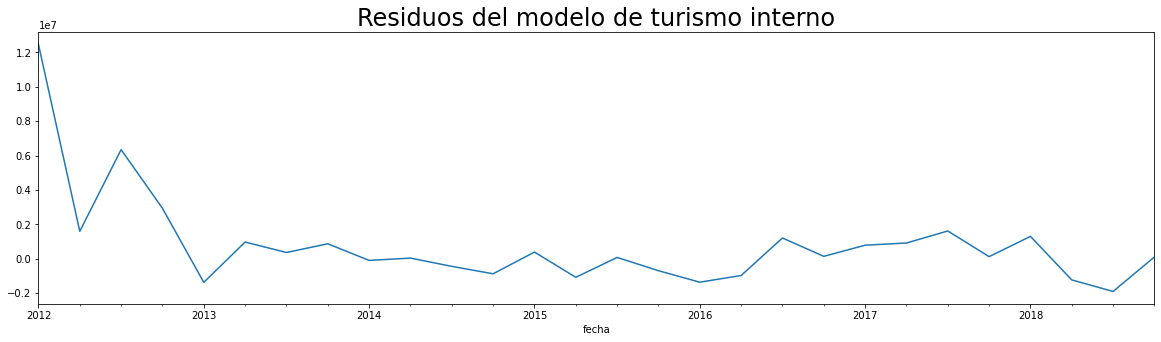

In [121]:
modelo_turismo_best_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo de turismo interno",size=24)
plt.show()

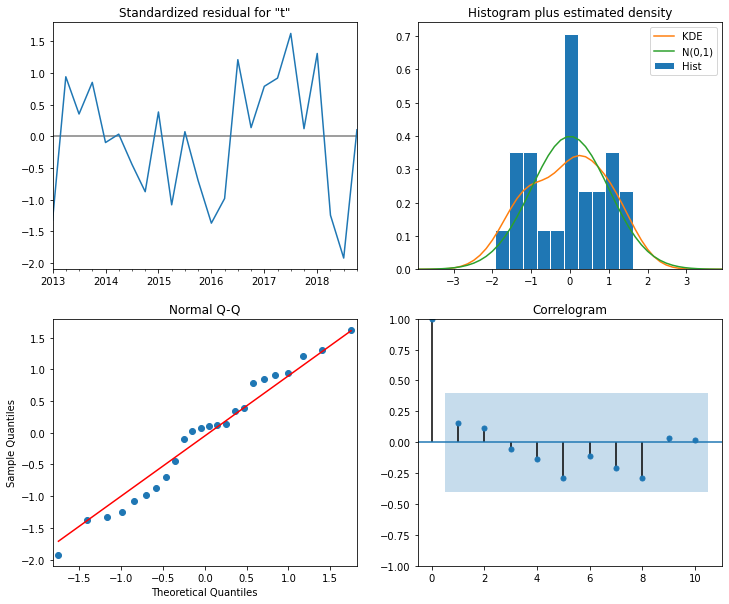

In [122]:
modelo_turismo_best_fit.plot_diagnostics(figsize=(12,10));

En el gráfico de los residuos estandarizados no parece verse una serie de ruido blanco. 
En el correlograma se observa que los lags de los residuos no son significativos por lo que no hay autocorrelación de los errores. 
En el Q-Q plot y en el histograma se observa que los residuos no siguen una distribución normal, por lo que este no es un buen modelo. 

A continuación probamos estas inferencias gráficas con tests apropiados para cada caso:

In [123]:
# Test de Ljung-Box (autocorrelación serial). H0: The residuals are independently distributed.
sm.stats.acorr_ljungbox(modelo_turismo_best_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,1.093716,0.295649
2,4.783743,0.091458
3,5.689253,0.127747
4,5.906242,0.206260
5,5.948971,0.311216


Todos los p-value son mayores al 5% por lo que no se evidencia autocorrelación serial de los errores. 

In [124]:
# Test de Jarque-Bera (normalidad). H0:sample S (Skewness) and sample K (Kurtosis) is not significantly different from normal distribution. 
jarque_bera(modelo_turismo_best_fit.resid)

Jarque_beraResult(statistic=143.26805395407527, pvalue=0.0)

El p-value es menor al 5%, por lo tanto se rechaza la H0 de normalidad. Los errores no siguen una distribución normal. 

Dado que el anterior modelo no es bueno, analizamos los residuos del segundo mejor modelo que encontramos, el SARIMA(1,0,1)(1,1,0,4):


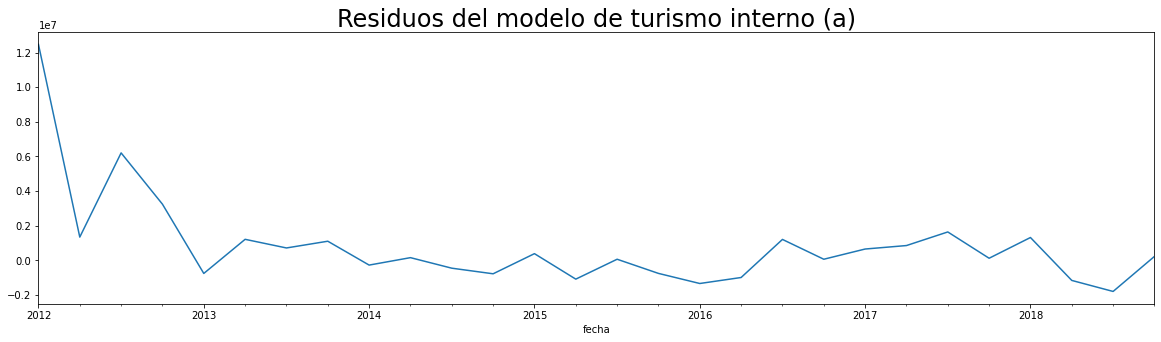

In [125]:
modelo_turismo_a_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo de turismo interno (a)",size=24)
plt.show()

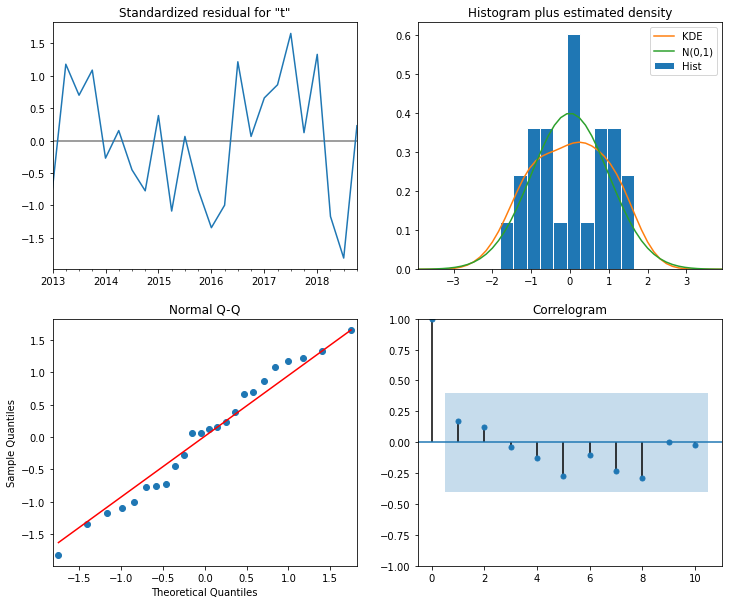

In [126]:
modelo_turismo_a_fit.plot_diagnostics(figsize=(12,10));

Obtenemos las mismas conclusiones que para el modelo anterior: los residuos no parecen ser ruido blanco. No hay autocorrelación de los errores. Los residuos no siguen una distribución normal. Asimismo, este no es un buen modelo. Quziás esta serie no deba ser estimada con un modelo de la familia de los ARIMA/SARIMA, sino con algún otro enfoque. A su vez, la poca cantidad de datos históricos, una realidad de la serie que no puede ser cambiada ya que los datos se empezaron a estimar en el año 2012, presenta un desafío que no puede ser resuelto con un SARIMA.

A continuación probamos estas inferencias gráficas con pruebas de hipótesis para cada caso.

In [127]:
# Test de Ljung-Box (autocorrelación serial). H0: The residuals are independently distributed.
sm.stats.acorr_ljungbox(modelo_turismo_a_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,0.957402,0.327842
2,4.918971,0.085479
3,6.228274,0.101017
4,6.265886,0.180152
5,6.363879,0.272404


Todos los p-value son mayores al 5% por lo que no se evidencia autocorrelación serial de los errores. 

In [128]:
# Test de Jarque-Bera (normalidad). H0:sample S (Skewness) and sample K (Kurtosis) is not significantly different from normal distribution. 
jarque_bera(modelo_turismo_a_fit.resid)

Jarque_beraResult(statistic=147.1750899151016, pvalue=0.0)

El p-value es menor al 5%, por lo tanto se rechaza la H0 de normalidad. Los errores no siguen una distribución normal. 

### Análisis de Diagnóstico para la serie de SALARIOS

Analizamos los residuos del mejor modelo que encontramos para esta serie: ARIMA(1,1,1) 

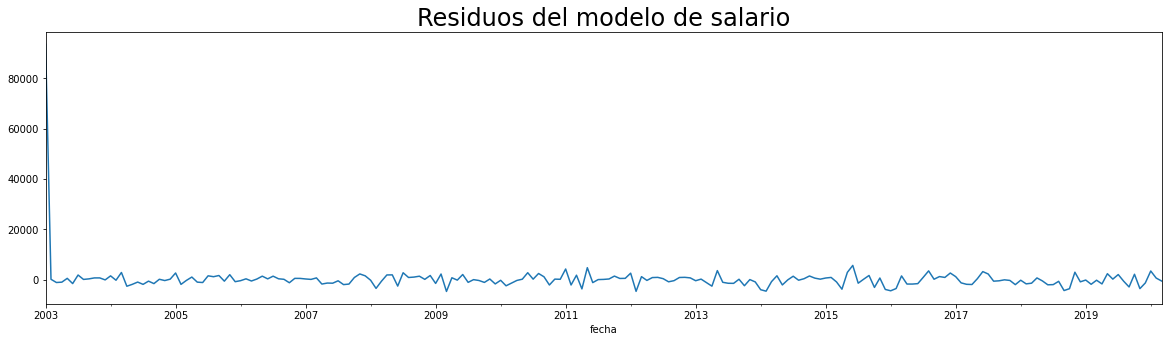

In [129]:
modelo_salario_c_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo de salario",size=24)
plt.show()

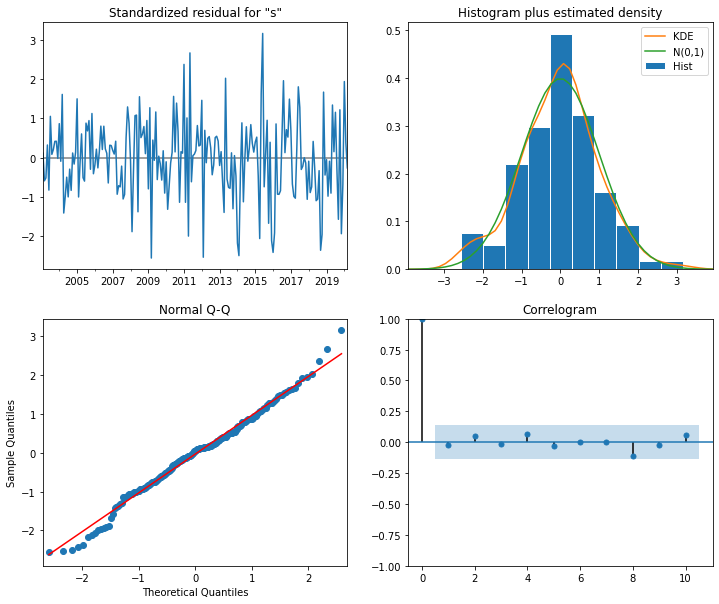

In [130]:
modelo_salario_c_fit.plot_diagnostics(figsize=(12,10));

En el gráfico de los residuos estandarizados parece verse una serie de ruido blanco, aunque pareciera haber heteroscedasticidad. 
En el correlograma se observa que los lags de los residuos no son significativos por lo que no hay autocorrelación de los errores. 
En el Q-Q plot y en el histograma se observa que los residuos siguen una distribución normal, por lo que este podría ser un buen modelo. A continuación probamos estas inferencias gráficas con pruebas de hipótesis para cada caso.


In [131]:
# Test de Ljung-Box (autocorrelación serial). H0: The residuals are independently distributed.
sm.stats.acorr_ljungbox(modelo_salario_c_fit.resid, lags=None)

,lb_stat,lb_pvalue
1,0.000359,0.984875
2,0.008984,0.995518
3,0.028874,0.998706
4,0.055875,0.999617
5,0.114374,0.999774
6,0.194538,0.999857
7,0.195699,0.999977
8,0.198533,0.999996
9,0.207493,0.999999
10,0.238976,1.000000


En todos los casos, no se puede rechazar la H0 de que los residuos son independientes. Entonces, comprobamos que no hay autocorrelación serial de los errores.


In [132]:
# Test de Breush-Pagan (heteroscedasticidad). 
#sm.stats.diagnostic.het_white(modelo_salario_c_fit.resid)




In [133]:
# Test de Jarque-Bera (normalidad). H0:sample S (Skewness) and sample K (Kurtosis) is not significantly different from normal distribution. 
from scipy.stats import jarque_bera
jarque_bera(modelo_salario_c_fit.resid)

Jarque_beraResult(statistic=266013.1312830062, pvalue=0.0)

El p-value es menor al 5%, por lo tanto se rechaza la H0 de normalidad. Los errores no siguen una distribución normal. 

## **Proyecciones**

In [134]:
def graficar_forecast(serie, serie_fit, serie_forecast, conf_int, ylabel, titulo="Proyecciones", xlabel="Periodo"):
          
    # Graficamos los datos originales, los datos fitted y la predicción
    serie.plot(label="Serie Original", figsize=(30,8))
    serie_fit.plot(label="Fit del modelo", figsize=(30,8))
    serie_forecast.plot(label="Serie proyectada", figsize=(30,8))
    
    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior", linestyle='dashed')
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior", linestyle='dashed')

    plt.title(titulo, size = 20)
    plt.ylabel(ylabel, size =20)
    #plt.xlabel(xlabel)
    plt.legend()
    

### Proyecciones de la serie de TURISMO INTERNO

A pesar de que anteriormente encontramos que no hay una especificación SARIMA que sea buena para explicar al turismo interno, a continuación realizamos una proyección con la especificación que mejor ajustaba a los datos de training, el SARIMA(1,0,1)(0,1,0,4):

In [135]:
modelo_turismo_final = SARIMAX(df_turismo_cut, order=(1,0,1), seasonal_order=(0,1,0,4))
modelo_turismo_final_fit = modelo_turismo_final.fit()
modelo_turismo_final_forecast = modelo_turismo_final_fit.get_forecast(4) # proyectamos 1 año


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [136]:
modelo_turismo_final_forecast.predicted_mean

2020-01-01    1.049436e+07
2020-04-01    4.008360e+06
2020-07-01    6.233810e+06
2020-10-01    6.352851e+06
Freq: QS-OCT, Name: predicted_mean, dtype: float64

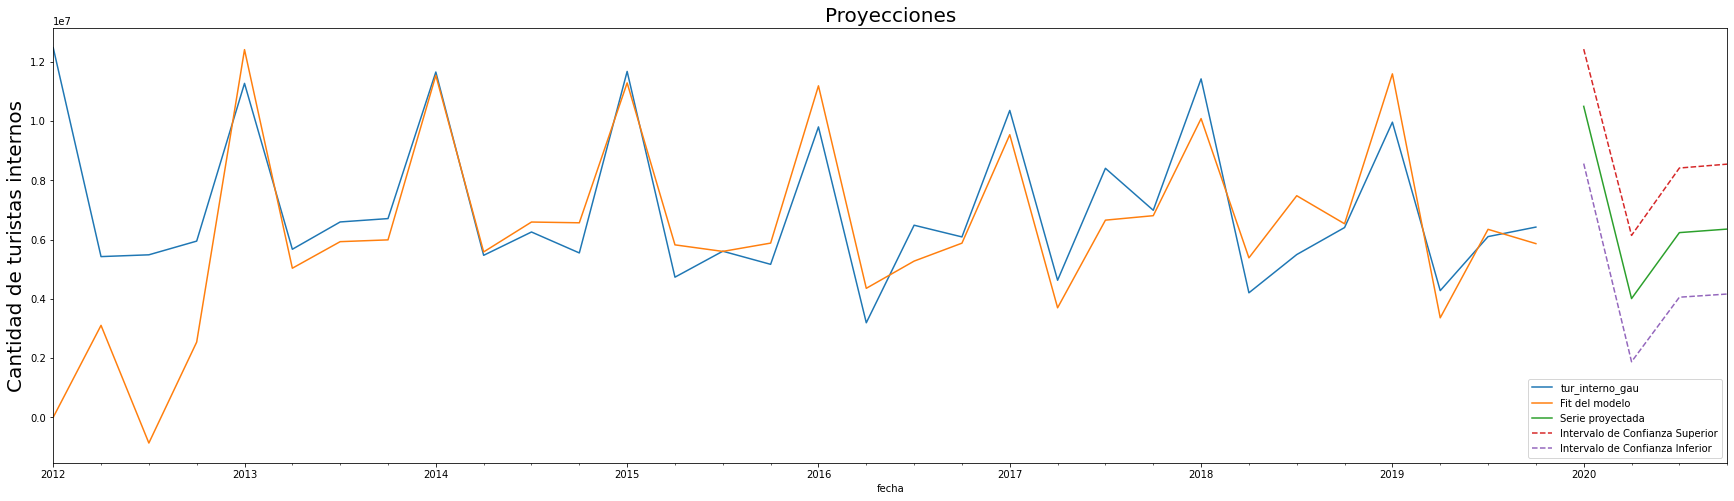

In [137]:
graficar_forecast(df_turismo_cut, modelo_turismo_final_fit.fittedvalues, modelo_turismo_final_forecast.predicted_mean, modelo_turismo_final_forecast.conf_int(), ylabel= "Cantidad de turistas internos")

### Proyecciones de la serie de SALARIO

In [138]:
modelo_salario_final = SARIMAX(df_salario_cut, order=(1,1,1))
modelo_salario_final_fit = modelo_salario_final.fit()
modelo_salario_final_forecast = modelo_salario_final_fit.get_forecast(12) # proyectamos 1 año


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [139]:
modelo_salario_final_forecast.predicted_mean

2022-04-01    140016.316322
2022-05-01    140010.503501
2022-06-01    140004.780137
2022-07-01    139999.144855
2022-08-01    139993.596299
2022-09-01    139988.133134
2022-10-01    139982.754046
2022-11-01    139977.457741
2022-12-01    139972.242945
2023-01-01    139967.108403
2023-02-01    139962.052881
2023-03-01    139957.075162
Freq: MS, Name: predicted_mean, dtype: float64

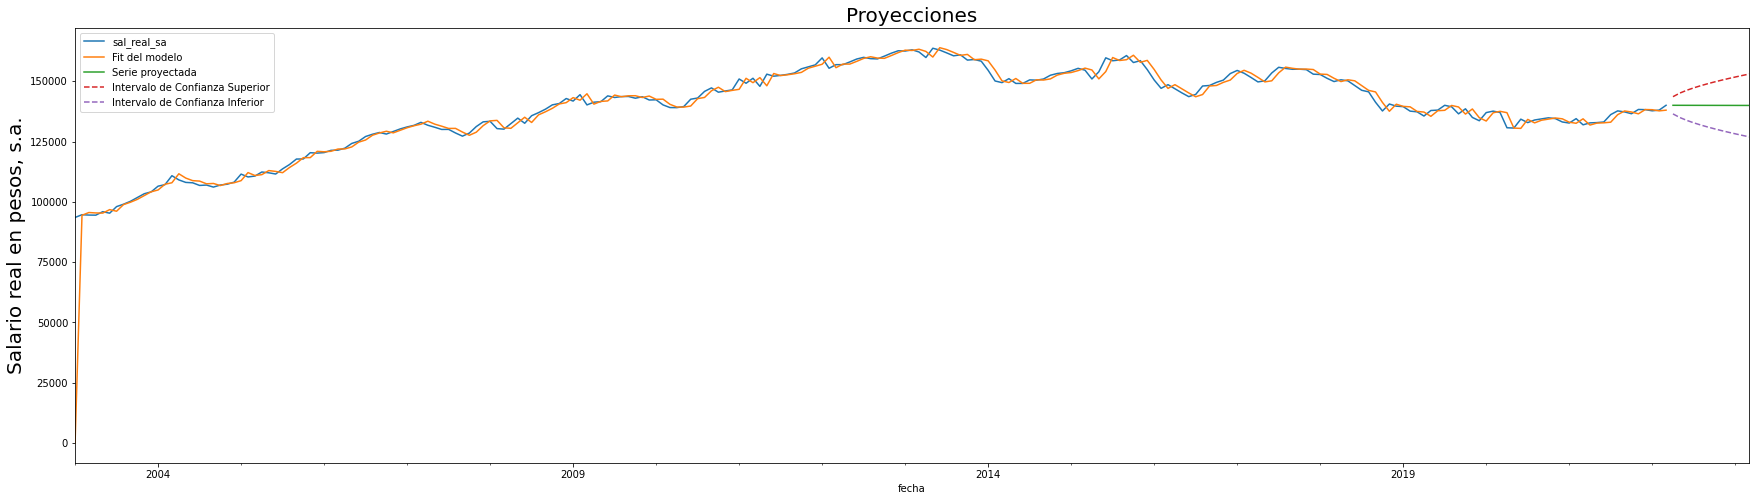

In [140]:
graficar_forecast(df_salario_cut, modelo_salario_final_fit.fittedvalues, modelo_salario_final_forecast.predicted_mean, modelo_salario_final_forecast.conf_int(), ylabel= "Salario real en pesos, s.a.")